In [1]:
import torch
import wandb
from matplotlib import pyplot as plt
from datetime import datetime
import os
from pathlib import Path
import sys
from torch.utils.data import DataLoader
import torch.optim as optim

# Jupyter 환경에서 BASE_PATH 설정
BASE_PATH = os.getcwd()

# 필요한 경로를 sys.path에 추가
sys.path.append(BASE_PATH)

# 경로 설정
CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_a_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints_a")
if not os.path.isdir(CHECKPOINT_a_FILE_PATH):
    os.makedirs(CHECKPOINT_a_FILE_PATH)

# 모듈 임포트
from _01_code._15_lstm_and_its_application.f_arg_parser import get_parser
from _01_code._14_rnn.g_rnn_trainer import RegressionTrainer
from _01_code._03_real_world_data_to_tensors.p_cryptocurrency_dataset_dataloader import get_cryptocurrency_data, \
  CryptoCurrencyDataset

# argparse 시뮬레이션
import sys
sys.argv = ['ipykernel_launcher.py', '--wandb', '--epochs=1000', '--batch_size=32', '--learning_rate=0.001', '--validation_intervals=5', '--early_stop_patience=30', '--early_stop_delta=0.0001']

# 파서 설정
parser = get_parser()
args = parser.parse_args()


In [2]:
def get_btc_krw_data(sequence_size=10, validation_size=100, test_size=10, is_regression=True):
  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=sequence_size, validation_size=validation_size, test_size=test_size,
      target_column='Close', y_normalizer=1.0e7, is_regression=is_regression
  )

  # print(X_train.shape, X_validation.shape, X_test.shape, y_train.shape, y_validation.shape, y_test.shape, "!!! - 1")

  # X_train.shape: [3212, 10, 5]
  # X_validation.shape: [100, 10, 5]
  # X_test.shape: [10, 10, 5]
  # y_train.shape: [3212]
  # y_validation.shape: [100]
  # y_test.shape: [10]

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  train_data_loader = DataLoader(
    dataset=train_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  validation_data_loader = DataLoader(
    dataset=validation_crypto_currency_dataset, batch_size=wandb.config.batch_size, shuffle=True
  )
  test_data_loader = DataLoader(
    dataset=test_crypto_currency_dataset, batch_size=len(test_crypto_currency_dataset), shuffle=True
  )

  return train_data_loader, validation_data_loader, test_data_loader



In [3]:
import torch.nn as nn

def get_model(n_input, n_output, hidden_size=128, num_layers=2):
    class MyModel(nn.Module):
        def __init__(self, n_input, n_output, hidden_size, num_layers):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
            self.fcn = nn.Linear(in_features=hidden_size, out_features=n_output)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # x.shape: [batch_size, hidden_size]
            x = self.fcn(x)
            return x

    my_model = MyModel(n_input, n_output, hidden_size, num_layers)
    return my_model

### g 실행

In [4]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ = get_btc_krw_data(sequence_size=21, validation_size=150, is_regression=True)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model(n_input=5, n_output=1, hidden_size=128, num_layers=2)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  regression_trainer = RegressionTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_a_FILE_PATH
  )
  regression_trainer.train_loop()
  wandb.finish()

if __name__ == "__main__":
  wandb.finish()
  main(args)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: marching12 (marching12-korea-university-of-technology-and-education). Use `wandb login --relogin` to force relogin
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=32, epochs=1000, learning_rate=0.001, weight_decay=0.0, validation_intervals=5, early_stop_patience=30, early_stop_delta=0.0001)
{'epochs': 1000, 'batch_size': 32, 'validation_intervals': 5, 'learning_rate': 0.001, 'early_stop_patience': 30, 'early_stop_delta': 0.0001, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 1.26584, V_loss: 1.37180, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.002
[Epoch   5] T_loss: 0.03158, V_loss: 0.74760, V_loss decreased (1.37180 --> 0.74760). Saving model... | T_time: 00:00:02, T_speed: 0.071
[Epoch  10] T_loss: 0.01909, V_loss: 0.54274, V_loss decreased (0.74760 --> 0.54274). Saving model... | T_time: 00:00:03, T_speed: 0.011
[Epoch  15] T_loss: 0.01642, V_loss: 0.39455, V_loss decreased (0.54274 --> 0.39455). Saving model... | T_time: 00:00:05, T_speed: 0.018
[Epoch  20] T_loss: 0.01347, V_loss: 0.40957, Early stopping counter: 1 out of 30 | T_time: 00:00:07, T_speed: 0.029
[Epoch  25] T_

Epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
Training loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Training speed (epochs/sec.),▁▁▁▁▁▁▁▁▂▃▁▁▁▁▁▂▂▆▁▁▂▂▃▇▁▁▂▂▂▃▅▁▂▂▂▂▃▄█▂
Validation loss,█▄▃▂▂▃▂▁▂▁▁▁▁▁▂▁▁▁▂▂▁▂▂▂▂▂▂▂▂▃▂▃▃▂▃▃▃▃▃▃
Epoch,195
Training loss,0.00498
Training speed (epochs/sec.),0.20393
Validation loss,0.61851


### h실행

In [5]:
def test(test_model):
  _, _, test_data_loader = get_btc_krw_data(test_size = 30)

  test_model.eval()

  y_normalizer = 100

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f} (Loss: {3:>13,.2f})".format(
        idx,
        output.item() * y_normalizer,
        target.item() * y_normalizer,
        abs(output.squeeze(dim=-1).item() - target.item()) * y_normalizer
      ))


def predict_all(test_model):
  y_normalizer = 100

  X_train, X_validation, X_test, y_train, y_validation, y_test, y_train_date, y_validation_date, y_test_date \
    = get_cryptocurrency_data(
      sequence_size=10, validation_size=100, test_size=10,
      target_column='Close', y_normalizer=1.0e7, is_regression=True
  )

  train_crypto_currency_dataset = CryptoCurrencyDataset(X=X_train, y=y_train)
  validation_crypto_currency_dataset = CryptoCurrencyDataset(X=X_validation, y=y_validation)
  test_crypto_currency_dataset = CryptoCurrencyDataset(X=X_test, y=y_test)

  dataset_list = [
    train_crypto_currency_dataset, validation_crypto_currency_dataset, test_crypto_currency_dataset
  ]
  dataset_labels = [
    "train", "validation", "test"
  ]
  num = 0
  fig, axs = plt.subplots(3, 1, figsize=(6, 9))

  for i in range(3):
    X = []
    TARGET_Y = []
    PREDICTION_Y = []
    for data in dataset_list[i]:
      input, target = data
      prediction = test_model(input.unsqueeze(0)).squeeze(-1).squeeze(-1)

      X.append(num)
      TARGET_Y.append(target.item() * y_normalizer)
      PREDICTION_Y.append(prediction.item() * y_normalizer)

      num += 1

    axs[i].plot(X, TARGET_Y, label='target')
    axs[i].plot(X, PREDICTION_Y, label='prediction')
    axs[i].set_title(dataset_labels[i])
    axs[i].legend()

  plt.tight_layout()
  plt.show()

MODEL FILE: /home/work/checkpoints_a/lstm_regression_btc_krw_checkpoint_latest.pt
[TEST DATA]
 0: 943.16 <--> 1,047.88 (Loss:        104.72)
 1: 1,069.60 <--> 1,286.65 (Loss:        217.05)
 2: 1,008.61 <--> 1,243.20 (Loss:        234.58)
 3: 1,074.89 <--> 1,254.02 (Loss:        179.13)
 4: 1,058.31 <--> 1,271.21 (Loss:        212.90)
 5: 1,039.92 <--> 1,272.01 (Loss:        232.09)
 6: 1,097.94 <--> 1,302.60 (Loss:        204.66)
 7: 918.77 <--> 1,059.85 (Loss:        141.09)
 8: 1,065.36 <--> 1,264.13 (Loss:        198.76)
 9: 1,087.89 <--> 1,360.09 (Loss:        272.20)
10: 1,076.92 <--> 1,380.87 (Loss:        303.95)
11: 1,074.76 <--> 1,259.24 (Loss:        184.49)
12: 940.63 <--> 959.09 (Loss:         18.46)
13: 1,006.55 <--> 1,125.35 (Loss:        118.80)
14: 980.99 <--> 1,070.26 (Loss:         89.26)
15: 1,089.49 <--> 1,284.38 (Loss:        194.89)
16: 1,052.09 <--> 1,224.73 (Loss:        172.63)
17: 1,033.46 <--> 1,238.69 (Loss:        205.24)
18: 1,084.39 <--> 1,331.62 (Loss: 

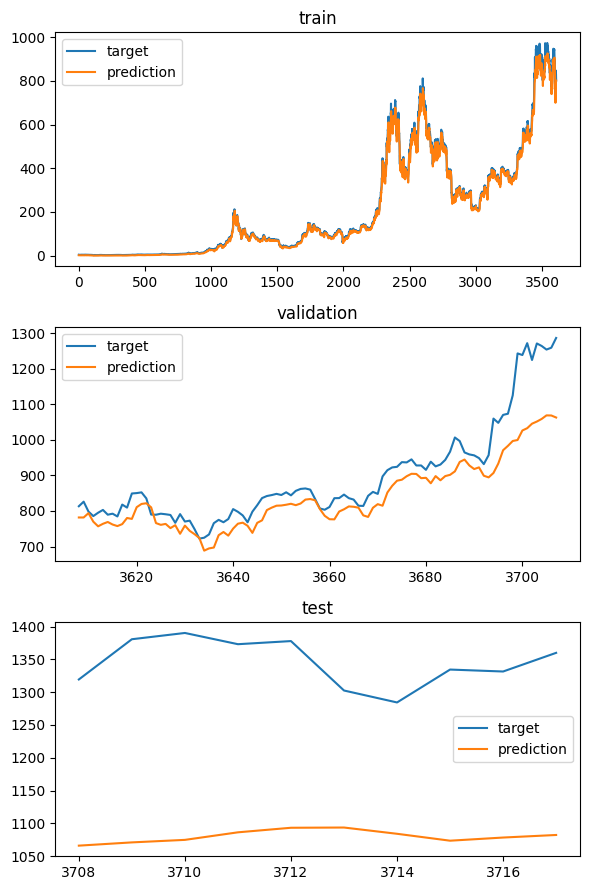

In [6]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_regression_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model(n_input=5, n_output=1, hidden_size=128, num_layers=2)

  project_name = "lstm_regression_btc_krw"
  latest_file_path = os.path.join(
    CHECKPOINT_a_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test(test_model)
  predict_all(test_model)

if __name__ == "__main__":
  main(args)

### i 실행

In [8]:
from _01_code._08_fcn_best_practice.c_trainer import ClassificationTrainer
CHECKPOINT_b_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints_b")
if not os.path.isdir(CHECKPOINT_b_FILE_PATH):
    os.makedirs(CHECKPOINT_b_FILE_PATH)

sys.argv = ['ipykernel_launcher.py',
            '--wandb', '--epochs=1000',
            '--batch_size=32',
            '--learning_rate=0.001',
            '--validation_intervals=5',
            '--early_stop_patience=30',
            '--early_stop_delta=0.0001',
            '--weight_decay=0.01' ]
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
    'weight_decay': args.weight_decay
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="online" if args.wandb else "disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "classification", "btc_krw"],
    name=run_time_str,
    config=config
  )
  print(args)
  print(wandb.config)

  train_data_loader, validation_data_loader, _ =get_btc_krw_data(sequence_size=21, validation_size=150, is_regression=False)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print(f"Training on device {device}.")

  model = get_model(n_input=5, n_output=2, hidden_size=256, num_layers=3)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)

  classification_trainer = ClassificationTrainer(
    project_name, model, optimizer, train_data_loader, validation_data_loader, None,
    run_time_str, wandb, device, CHECKPOINT_b_FILE_PATH
  )
  classification_trainer.train_loop()

  wandb.finish()


if __name__ == "__main__":
  wandb.finish()
  main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Namespace(wandb=True, batch_size=32, epochs=1000, learning_rate=0.001, weight_decay=0.0, validation_intervals=5, early_stop_patience=30, early_stop_delta=0.0001)
{'epochs': 1000, 'batch_size': 32, 'validation_intervals': 5, 'learning_rate': 0.001, 'early_stop_patience': 30, 'early_stop_delta': 0.0001, 'weight_decay': 0.0}
Training on device cuda:0.
[Epoch   1] T_loss: 0.69217, T_accuracy: 52.9180 | V_loss: 0.69158, V_accuracy: 53.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch   5] T_loss: 0.69152, T_accuracy: 52.8616 | V_loss: 0.69147, V_accuracy: 53.3333 | V_loss decreased (0.69158 --> 0.69147). Saving model... | T_time: 00:00:03, T_speed: 1.667
[Epoch  10] T_loss: 0.69175, T_accuracy: 52.6924 | V_loss: 0.69262, V_accuracy: 51.3333 | Early stopping counter: 1 out of 30 | T_time: 00:00:07, T_speed: 1.429
[Epoch  15] T_loss: 0.69132, T_accuracy: 52.9180 | V_loss: 0.69132, V_accuracy: 53.3333 | V_loss decreased (0.69147 --> 0.69132). Saving model... | T_time: 

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
Training accuracy (%),▇▅█▁▄█████████████████▇▅▃████████████▆█▇
Training loss,█▅▆▄▄▅▅▆▅▅▅▅▅▄▅▅▅▅▅▃▂▂▁▁▆▅▅▅▅▅▅▅▅▅▅▄▄▄▃▁
Training speed (epochs/sec.),▁█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
Validation accuracy (%),██▆█▁████████████████████▁██████████████
Validation loss,▂▂▃▂█▂▂▁▂▃▂▃▂▃▁▁▁▂▂▂▂▃▃▂▃▁▂▁▂▁▃▂▁▂▁▃▃▂▃▄
Epoch,240
Training accuracy (%),52.83338
Training loss,0.69083
Training speed (epochs/sec.),1.42012
Validation accuracy (%),53.33333


### j 실행

In [10]:
def testj(test_model):
  _, _, test_data_loader = get_btc_krw_data(test_size=30, is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

In [11]:
def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
    'epochs': args.epochs,
    'batch_size': args.batch_size,
    'validation_intervals': args.validation_intervals,
    'learning_rate': args.learning_rate,
    'early_stop_patience': args.early_stop_patience,
    'early_stop_delta': args.early_stop_delta,
  }

  project_name = "lstm_classification_btc_krw"
  wandb.init(
    mode="disabled",
    project=project_name,
    notes="btc_krw experiment with lstm",
    tags=["lstm", "regression", "btc_krw"],
    name=run_time_str,
    config=config
  )

  test_model = get_model(n_input=5, n_output=2, hidden_size=256, num_layers=3)

  latest_file_path = os.path.join(
    CHECKPOINT_b_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  testj(test_model)


if __name__ == "__main__":
    wandb.finish()
    main(args)

MODEL FILE: /home/work/checkpoints_b/lstm_classification_btc_krw_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 53.333%
 0:   1.00 <-->   1.00
 1:   1.00 <-->   0.00
 2:   1.00 <-->   1.00
 3:   1.00 <-->   0.00
 4:   1.00 <-->   0.00
 5:   1.00 <-->   1.00
 6:   1.00 <-->   0.00
 7:   1.00 <-->   1.00
 8:   1.00 <-->   1.00
 9:   1.00 <-->   0.00
10:   1.00 <-->   0.00
11:   1.00 <-->   0.00
12:   1.00 <-->   0.00
13:   1.00 <-->   0.00
14:   1.00 <-->   1.00
15:   1.00 <-->   0.00
16:   1.00 <-->   1.00
17:   1.00 <-->   1.00
18:   1.00 <-->   1.00
19:   1.00 <-->   1.00
20:   1.00 <-->   0.00
21:   1.00 <-->   1.00
22:   1.00 <-->   1.00
23:   1.00 <-->   0.00
24:   1.00 <-->   0.00
25:   1.00 <-->   1.00
26:   1.00 <-->   1.00
27:   1.00 <-->   0.00
28:   1.00 <-->   1.00
29:   1.00 <-->   1.00


### 문제2

In [12]:
def get_model_new(n_input=5, n_output=1, hidden_size=128, n_lstm_layers=2, n_linear_layers=1, dropout_rate=0.3):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.lstm = nn.LSTM(input_size=n_input, hidden_size=hidden_size, num_layers=n_lstm_layers, batch_first=True, dropout=dropout_rate)
            linear_layers = [nn.Linear(hidden_size if i == 0 else 64, 64 if i < n_linear_layers - 1 else n_output) for i in range(n_linear_layers)]
            self.linear_layers = nn.Sequential(*linear_layers)

        def forward(self, x):
            x, _ = self.lstm(x)
            x = x[:, -1, :]  # 마지막 시퀀스 출력
            x = self.linear_layers(x)
            return x

    return MyModel()

In [29]:
CURRENT_FILE_PATH = BASE_PATH
CHECKPOINT_a_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints_a")
if not os.path.isdir(CHECKPOINT_a_FILE_PATH):
    os.makedirs(CHECKPOINT_a_FILE_PATH)
def main(args):
    # 시간 기록을 위한 문자열
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    
    # WandB 설정
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "lstm_regression_btc_krw_new"
    
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw_new"],
        name=run_time_str,
        config=config
      )


    # 데이터 로딩
    train_loader, val_loader, test_loader = get_btc_krw_data(
        sequence_size=21, validation_size=150, test_size=30, is_regression=True
    )

    # 모델 설정
    model = get_model_new(
        n_input=5, n_output=1, hidden_size=256,
        n_lstm_layers=3, n_linear_layers=2, dropout_rate=0.2
    )
    
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=0.0001)
    model.to(device)
    # 트레이너 생성 및 훈련
    regression_trainer = RegressionTrainer(
        project_name, model, optimizer,
        train_loader, val_loader, None, run_time_str, wandb, device,
        CHECKPOINT_a_FILE_PATH
    )
    regression_trainer.train_loop()
    
    wandb.finish()


if __name__ == "__main__":
    wandb.finish()
    main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


[Epoch   1] T_loss: 0.89983, V_loss: 0.36817, Early stopping is stated! | T_time: 00:00:00, T_speed: 0.001
[Epoch   5] T_loss: 0.04000, V_loss: 0.12434, V_loss decreased (0.36817 --> 0.12434). Saving model... | T_time: 00:00:03, T_speed: 0.008
[Epoch  10] T_loss: 0.03105, V_loss: 0.31741, Early stopping counter: 1 out of 30 | T_time: 00:00:07, T_speed: 0.033
[Epoch  15] T_loss: 0.02597, V_loss: 0.09744, V_loss decreased (0.12434 --> 0.09744). Saving model... | T_time: 00:00:10, T_speed: 0.016
[Epoch  20] T_loss: 0.02481, V_loss: 0.07271, V_loss decreased (0.09744 --> 0.07271). Saving model... | T_time: 00:00:14, T_speed: 0.032
[Epoch  25] T_loss: 0.02862, V_loss: 0.07584, Early stopping counter: 1 out of 30 | T_time: 00:00:18, T_speed: 0.085
[Epoch  30] T_loss: 0.02538, V_loss: 0.06985, V_loss decreased (0.07271 --> 0.06985). Saving model... | T_time: 00:00:21, T_speed: 0.032
[Epoch  35] T_loss: 0.02567, V_loss: 0.17899, Early stopping counter: 1 out of 30 | T_time: 00:00:25, T_speed: 

[Epoch 345] T_loss: 0.01505, V_loss: 0.07091, Early stopping counter: 8 out of 30 | T_time: 00:04:12, T_speed: 10.771
[Epoch 350] T_loss: 0.01485, V_loss: 0.06704, Early stopping counter: 9 out of 30 | T_time: 00:04:15, T_speed: 0.521
[Epoch 355] T_loss: 0.01506, V_loss: 0.08886, Early stopping counter: 10 out of 30 | T_time: 00:04:19, T_speed: 1.287
[Epoch 360] T_loss: 0.01481, V_loss: 0.08850, Early stopping counter: 11 out of 30 | T_time: 00:04:22, T_speed: 0.387
[Epoch 365] T_loss: 0.01558, V_loss: 0.06901, Early stopping counter: 12 out of 30 | T_time: 00:04:26, T_speed: 0.622
[Epoch 370] T_loss: 0.01576, V_loss: 0.09716, Early stopping counter: 13 out of 30 | T_time: 00:04:30, T_speed: 1.668
[Epoch 375] T_loss: 0.01507, V_loss: 0.06389, Early stopping counter: 14 out of 30 | T_time: 00:04:33, T_speed: 0.426
[Epoch 380] T_loss: 0.01540, V_loss: 0.08420, Early stopping counter: 15 out of 30 | T_time: 00:04:37, T_speed: 0.722
[Epoch 385] T_loss: 0.01471, V_loss: 0.09378, Early stopp

Epoch,▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇██
Training loss,▇▆█▃▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▁▂▁▂▂▂▁▁▂▂▂▂
Training speed (epochs/sec.),▁▁▁▁▁▁▁▃▂▂▂▅▂▆▂▂▂▅▆▂▂▃▂▃▂▃▄▅▃▆▆▄▃▃▇▄█▃▃▃
Validation loss,█▇▁▁▁▁▁▃▁▂▁▂▂▂▃▂▂▂▂▂▁▁▂▂▃▂▂▁▂▂▁▁▃▂▁▁▂▁▁▂
Epoch,625
Training loss,0.01507
Training speed (epochs/sec.),5.1786
Validation loss,0.06853


/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


MODEL FILE: /home/work/checkpoints_a/lstm_regression_btc_krw_new_checkpoint_latest.pt
[TEST DATA]
 0: 1,009.85 <--> 1,284.38 (Loss:        274.54)
 1: 1,009.32 <--> 1,319.45 (Loss:        310.13)
 2: 925.71 <--> 964.63 (Loss:         38.92)
 3: 1,026.68 <--> 1,373.29 (Loss:        346.61)
 4: 1,003.85 <--> 1,286.65 (Loss:        282.80)
 5: 1,004.91 <--> 1,259.24 (Loss:        254.34)
 6: 909.94 <--> 948.70 (Loss:         38.76)
 7: 1,008.23 <--> 1,254.02 (Loss:        245.79)
 8: 1,022.63 <--> 1,390.43 (Loss:        367.80)
 9: 909.99 <--> 956.43 (Loss:         46.44)
10: 1,007.87 <--> 1,264.13 (Loss:        256.26)
11: 914.55 <--> 959.09 (Loss:         44.54)
12: 971.42 <--> 1,243.20 (Loss:        271.78)
13: 937.50 <--> 1,047.88 (Loss:        110.37)
14: 1,018.25 <--> 1,360.09 (Loss:        341.85)
15: 960.74 <--> 1,125.35 (Loss:        164.61)
16: 901.96 <--> 931.83 (Loss:         29.88)
17: 1,026.34 <--> 1,378.05 (Loss:        351.71)
18: 995.18 <--> 1,272.01 (Loss:        276.83)

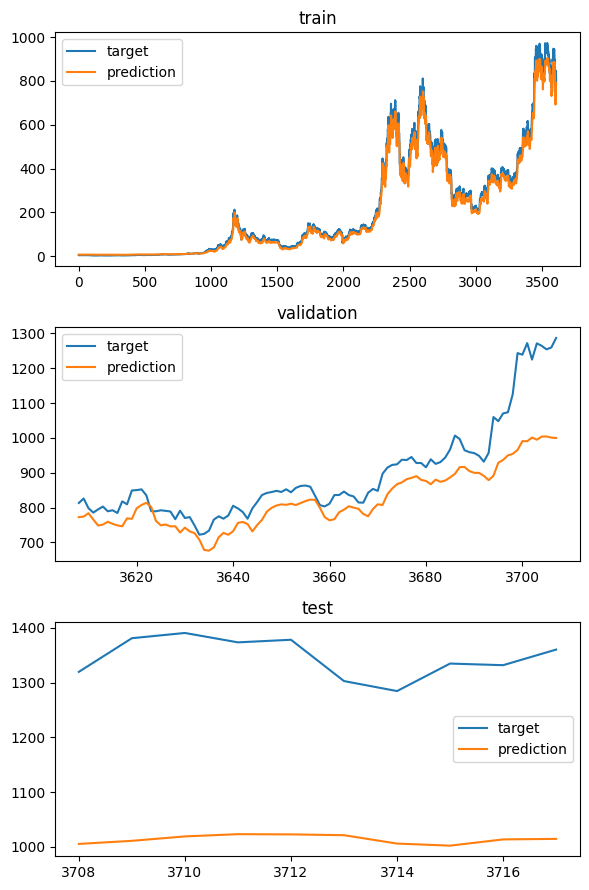

In [32]:
def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')
    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
    }

    project_name = "lstm_regression_btc_krw_new"
    
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="btc_krw experiment with lstm",
        tags=["lstm", "regression", "btc_krw_new"],
        name=run_time_str,
        config=config
      )

    test_model = model = get_model_new(
        n_input=5, n_output=1, hidden_size=256,
        n_lstm_layers=3, n_linear_layers=2, dropout_rate=0.2
    )

    project_name = "lstm_regression_btc_krw_new"
    latest_file_path = os.path.join(
    CHECKPOINT_a_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
    )
    print("MODEL FILE: {0}".format(latest_file_path))
    test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

    test(test_model)
    predict_all(test_model)

if __name__ == "__main__":
    main(args)

In [37]:
CHECKPOINT_b_FILE_PATH = os.path.join(CURRENT_FILE_PATH, "checkpoints_b")
if not os.path.isdir(CHECKPOINT_b_FILE_PATH):
    os.makedirs(CHECKPOINT_b_FILE_PATH)
    
def get_model_b(n_input, n_output, lstm_layers=3, fc_layers=1, dropout_rate=0.0):
    class MyModel(nn.Module):
        def __init__(self):
            super().__init__()

            # LSTM 레이어 설정
            self.lstm = nn.LSTM(
                input_size=n_input, 
                hidden_size=256, 
                num_layers=lstm_layers, 
                batch_first=True, 
                dropout=dropout_rate if lstm_layers > 1 else 0.0
            )

            # FCN 레이어 설정
            fc_modules = []
            in_features = 256  # LSTM의 hidden_size

            for _ in range(fc_layers - 1):
                fc_modules.append(nn.Linear(in_features, in_features // 2))
                fc_modules.append(nn.ReLU())
                fc_modules.append(nn.Dropout(p=dropout_rate))
                in_features = in_features // 2

            fc_modules.append(nn.Linear(in_features, n_output))
            self.fcn = nn.Sequential(*fc_modules)

        def forward(self, x):
            x, hidden = self.lstm(x)
            x = x[:, -1, :]  # 마지막 타임스텝의 출력만 사용
            x = self.fcn(x)
            return x

    return MyModel()


def main(args):
    run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

    config = {
        'epochs': args.epochs,
        'batch_size': args.batch_size,
        'validation_intervals': args.validation_intervals,
        'learning_rate': args.learning_rate,
        'early_stop_patience': args.early_stop_patience,
        'early_stop_delta': args.early_stop_delta,
        'weight_decay': args.weight_decay,
        'dropout_rate': args.dropout_rate,
        'lstm_layers': args.lstm_layers,
        'fc_layers': args.fc_layers
    }

    project_name = "lstm_tuning_btc_krw_Q2"
    wandb.init(
        mode="online" if args.wandb else "disabled",
        project=project_name,
        notes="Tuning LSTM and FCN layers with dropout",
        tags=["lstm", "classification", "btc_krw", "tuning"],
        name=run_time_str,
        config=config
    )

    wandb.config.update({
        'weight_decay': args.weight_decay,
        'dropout_rate': args.dropout_rate,
        'lstm_layers': args.lstm_layers,
        'fc_layers': args.fc_layers
    }, allow_val_change=True)

    train_data_loader, validation_data_loader, _ = get_btc_krw_data(sequence_size=21, validation_size=150, test_size=30, is_regression=False)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Training on device {device}.")

    model = get_model_b(
        n_input=5, 
        n_output=2, 
        lstm_layers=wandb.config.lstm_layers, 
        fc_layers=wandb.config.fc_layers, 
        dropout_rate=wandb.config.dropout_rate
    )
    model.to(device)

    optimizer = optim.Adam(
        model.parameters(), 
        lr=wandb.config.learning_rate, 
        weight_decay=wandb.config.weight_decay
    )

    classification_trainer = ClassificationTrainer(
        project_name, model, optimizer, train_data_loader, validation_data_loader, None,
        run_time_str, wandb, device, CHECKPOINT_b_FILE_PATH
    )
    classification_trainer.train_loop()

    wandb.finish()

if __name__ == "__main__":
    class Args:
        wandb = True
        batch_size = 1024
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 0.0
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6
        dropout_rate = 0.0
        lstm_layers = 2  # LSTM 레이어 증가
        fc_layers = 1  # FCN 레이어 증가
    wandb.finish()
    args = Args()
    main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


Training on device cuda:0.
[Epoch   1] T_loss: 0.69166, T_accuracy: 53.3031 | V_loss: 0.69344, V_accuracy: 47.3333 | Early stopping is stated! | T_time: 00:00:00, T_speed: 0.000
[Epoch  30] T_loss: 0.68972, T_accuracy: 53.0479 | V_loss: 0.69382, V_accuracy: 46.6667 | Early stopping counter: 1 out of 30 | T_time: 00:00:01, T_speed: 30.000
[Epoch  60] T_loss: 0.69080, T_accuracy: 53.3598 | V_loss: 0.69379, V_accuracy: 45.3333 | Early stopping counter: 2 out of 30 | T_time: 00:00:03, T_speed: 20.000
[Epoch  90] T_loss: 0.69052, T_accuracy: 53.4165 | V_loss: 0.69355, V_accuracy: 47.3333 | Early stopping counter: 3 out of 30 | T_time: 00:00:05, T_speed: 18.000
[Epoch 120] T_loss: 0.69012, T_accuracy: 53.4165 | V_loss: 0.69387, V_accuracy: 47.3333 | Early stopping counter: 4 out of 30 | T_time: 00:00:07, T_speed: 17.143
[Epoch 150] T_loss: 0.69108, T_accuracy: 53.2464 | V_loss: 0.69276, V_accuracy: 52.6667 | V_loss decreased (0.69344 --> 0.69276). Saving model... | T_time: 00:00:09, T_speed:

Epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
Training accuracy (%),▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▃▄▄▄▅▅▅▆▆▆▆▇▇▆▇▇▇█▇█
Training loss,███████████▇▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▃▃▃▂▂▄▂▂▂▁▂▁
Training speed (epochs/sec.),▁█▆▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄
Validation accuracy (%),▂▂▁▂▂▅▃▃▅▆▆▆█▅██▅▇█▅▃▃▅▅▅▅▄▄▄▆▄▅▅▆▄▄▄▅▅▅
Validation loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇█
Epoch,1260
Training accuracy (%),63.907
Training loss,0.55796
Training speed (epochs/sec.),14.31818
Validation accuracy (%),52.66667


In [36]:
def test_b(test_model):
  _, _, test_data_loader = get_btc_krw_data(is_regression=False)

  test_model.eval()

  num_corrects_test = 0
  num_tested_samples = 0

  print("[TEST DATA]")
  with torch.no_grad():
    for test_batch in test_data_loader:
      input_test, target_test = test_batch

      output_test = test_model(input_test)

      predicted_test = torch.argmax(output_test, dim=1)
      num_corrects_test += torch.sum(torch.eq(predicted_test, target_test))

      num_tested_samples += len(input_test)

    test_accuracy = 100.0 * num_corrects_test / num_tested_samples

    print(f"TEST RESULTS: {test_accuracy:6.3f}%")

    for idx, (output, target) in enumerate(zip(output_test, target_test)):
      print("{0:2}: {1:6,.2f} <--> {2:6,.2f}".format(
        idx, torch.argmax(output).item(), target.item()
      ))

def main(args):
  run_time_str = datetime.now().astimezone().strftime('%Y-%m-%d_%H-%M-%S')

  config = {
      'epochs': args.epochs,
      'batch_size': args.batch_size,
      'validation_intervals': args.validation_intervals,
      'learning_rate': args.learning_rate,
      'early_stop_patience': args.early_stop_patience,
      'early_stop_delta': args.early_stop_delta,
      'weight_decay': args.weight_decay,
      'dropout_rate': args.dropout_rate,
      'lstm_layers': args.lstm_layers,
      'fc_layers': args.fc_layers
  }

  project_name = "lstm_tuning_btc_krw_Q2"
  wandb.init(
      mode="online" if args.wandb else "disabled",
      project=project_name,
      notes="Tuning LSTM and FCN layers with dropout",
      tags=["lstm", "classification", "btc_krw", "tuning"],
      name=run_time_str,
      config=config
  )

  wandb.config.update({
      'weight_decay': args.weight_decay,
      'dropout_rate': args.dropout_rate,
      'lstm_layers': args.lstm_layers,
      'fc_layers': args.fc_layers
  }, allow_val_change=True)

  test_model = get_model_b(
      n_input=5, 
      n_output=2, 
      lstm_layers=wandb.config.lstm_layers, 
      fc_layers=wandb.config.fc_layers, 
      dropout_rate=wandb.config.dropout_rate
  )
  latest_file_path = os.path.join(
    CHECKPOINT_b_FILE_PATH, f"{project_name}_checkpoint_latest.pt"
  )
  print("MODEL FILE: {0}".format(latest_file_path))
  test_model.load_state_dict(torch.load(latest_file_path, map_location=torch.device('cpu')))

  test_b(test_model)


if __name__ == "__main__":
    class Args:
        wandb = True
        batch_size = 1024
        epochs = 10000
        learning_rate = 1e-4
        weight_decay = 0.0
        validation_intervals = 30
        early_stop_patience = 30
        early_stop_delta = 1e-6
        dropout_rate = 0.0
        lstm_layers = 2  # LSTM 레이어 증가
        fc_layers = 1  # FCN 레이어 증가
    wandb.finish()
    main(args)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(
/usr/local/lib/python3.10/dist-packages/pydantic/main.py:314: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


MODEL FILE: /home/work/checkpoints_b/lstm_tuning_btc_krw_Q2_checkpoint_latest.pt
[TEST DATA]
TEST RESULTS: 60.000%
 0:   1.00 <-->   1.00
 1:   0.00 <-->   1.00
 2:   1.00 <-->   0.00
 3:   1.00 <-->   1.00
 4:   1.00 <-->   1.00
 5:   0.00 <-->   0.00
 6:   0.00 <-->   0.00
 7:   0.00 <-->   1.00
 8:   1.00 <-->   0.00
 9:   1.00 <-->   1.00


* https://wandb.ai/marching12-korea-university-of-technology-and-education/lstm_regression_btc_krw/reports/-1-1--VmlldzoxMDY3NDY1OA

* https://wandb.ai/marching12-korea-university-of-technology-and-education/lstm_classification_btc_krw/reports/-1_2--VmlldzoxMDY3NDczNw

* https://wandb.ai/marching12-korea-university-of-technology-and-education/lstm_regression_btc_krw_new/reports/-2-1--VmlldzoxMDY3NDc2MQ

* https://wandb.ai/marching12-korea-university-of-technology-and-education/lstm_tuning_btc_krw_Q2/reports/-2-2--VmlldzoxMDY3NDc2OA